In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=f8110e4b60c5090adb9b5591bf7b5016a263afa389657e433f5ad2a8d948d358
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [10]:
import yfinance as yf
import pandas as pd
import ta

# Fetch the Nasdaq Composite historical data
nas = yf.Ticker("^IXIC")
nas = nas.history(period="max")

# Add technical indicators
nas['MACD'] = ta.trend.macd(nas['Close'])
nas['MACD_Signal'] = ta.trend.macd_signal(nas['Close'])
nas['RSI'] = ta.momentum.rsi(nas['Close'])
bollinger = ta.volatility.BollingerBands(nas['Close'])
nas['Bollinger_High'] = bollinger.bollinger_hband()
nas['Bollinger_Low'] = bollinger.bollinger_lband()
nas['Stochastic'] = ta.momentum.stoch(nas['High'], nas['Low'], nas['Close'])
nas['ATR'] = ta.volatility.average_true_range(nas['High'], nas['Low'], nas['Close'])
nas['EMA'] = ta.trend.ema_indicator(nas['Close'])

# Shift tomorrow's close price for target calculation
nas["Tomorrow"] = nas["Close"].shift(-1)
nas["Target"] = (nas["Tomorrow"] > nas["Close"]).astype(int)

# Remove unnecessary columns and fill NaNs
nas.drop(columns=["Dividends", "Stock Splits"], inplace=True)
nas = nas.loc["2000-01-01":].copy()
nas.dropna(inplace=True)

# Normalize the predictors
from sklearn.preprocessing import StandardScaler
predictors = ["Close", "Volume", "Open", "High", "Low", "MACD", "MACD_Signal", "RSI", "Bollinger_High", "Bollinger_Low", "Stochastic", "ATR", "EMA"]
scaler = StandardScaler()
nas[predictors] = scaler.fit_transform(nas[predictors])

In [6]:
pip install pymdptoolbox

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25656 sha256=b4ea3f6a1f2851eec3e28163e2680a17809036213c47222d195fdadbc97eeadb
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox


In [12]:
import mdptoolbox
import numpy as np

# Define states and actions
states = nas.index
actions = [0, 1]  # 0: Hold, 1: Buy

# Initialize transition probability matrix P and reward matrix R
n_states = len(states)
n_actions = len(actions)
P = np.zeros((n_actions, n_states, n_states))
R = np.zeros((n_states, n_actions))

# Populate P and R
for i in range(n_states - 1):
    state = i
    next_state = i + 1
    reward_hold = 0
    reward_buy = nas.iloc[next_state]['Close'] - nas.iloc[state]['Close']

    P[0, state, next_state] = 1  # Transition probability for holding
    P[1, state, next_state] = 1  # Transition probability for buying
    R[state, 0] = reward_hold  # Reward for holding
    R[state, 1] = reward_buy  # Reward for buying

# Handle the last state separately to avoid transition issues
P[0, n_states-1, n_states-1] = 1  # Transition to itself
P[1, n_states-1, n_states-1] = 1  # Transition to itself
R[n_states-1, 0] = 0
R[n_states-1, 1] = 0

# Ensure P is stochastic
for a in range(n_actions):
    for s in range(n_states):
        if P[a, s].sum() > 0:
            P[a, s] /= P[a, s].sum()

# Check if P is stochastic
for a in range(n_actions):
    for s in range(n_states):
        assert np.isclose(P[a, s].sum(), 1.0), f"Row {s} of action {a} in P is not stochastic."

Precision: 1.0


<Axes: xlabel='Date'>

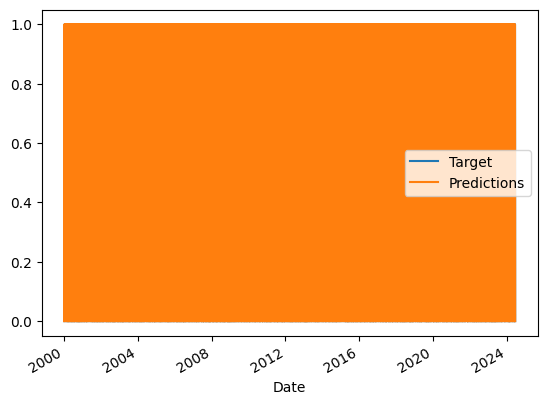

In [13]:
# Solve MDP using Policy Iteration
mdp = mdptoolbox.mdp.PolicyIteration(P, R, 0.9)
mdp.run()

# Get optimal policy
optimal_policy = mdp.policy

# Use optimal policy to make predictions
predictions = [optimal_policy[i] for i in range(len(states))]

# Convert predictions to a pandas series
predictions = pd.Series(predictions, index=nas.index, name='Predictions')

# Combine predictions with actual target
combined = pd.concat([nas['Target'], predictions], axis=1)

# Evaluate performance
from sklearn.metrics import precision_score
precision = precision_score(combined['Target'], combined['Predictions'])
print(f"Precision: {precision}")

# Plot combined results
combined.plot()

In [14]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score

# Calculate recall
recall = recall_score(combined['Target'], combined['Predictions'])
print(f"Recall: {recall}")

# Calculate F1-score
f1 = f1_score(combined['Target'], combined['Predictions'])
print(f"F1 Score: {f1}")

# Calculate accuracy
accuracy = accuracy_score(combined['Target'], combined['Predictions'])
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(combined['Target'], combined['Predictions'])
print("Confusion Matrix:")
print(conf_matrix)

Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
Confusion Matrix:
[[2822    0]
 [   0 3331]]


In [16]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Perform cross-validation
cross_val_scores = cross_val_score(model, nas[predictors], nas["Target"], cv=kf, scoring='precision')

print(f"Cross-Validation Precision Scores: {cross_val_scores}")
print(f"Average Cross-Validation Precision: {np.mean(cross_val_scores)}")
print("\nExplanation:")
print("Cross-validation helps us see how well our model performs on different parts of the data. "
      "We split the data into 5 parts and test the model on each part to ensure it's not just good at one specific set. "
      "The precision scores tell us how accurate our positive predictions are. The closer these scores are to each other and to 1.0, "
      "the more reliable our model is.")

# Check other metrics
cross_val_recall = cross_val_score(model, nas[predictors], nas["Target"], cv=kf, scoring='recall')
cross_val_f1 = cross_val_score(model, nas[predictors], nas["Target"], cv=kf, scoring='f1')
cross_val_accuracy = cross_val_score(model, nas[predictors], nas["Target"], cv=kf, scoring='accuracy')

print(f"Cross-Validation Recall Scores: {cross_val_recall}")
print(f"Average Cross-Validation Recall: {np.mean(cross_val_recall)}")

print(f"Cross-Validation F1 Scores: {cross_val_f1}")
print(f"Average Cross-Validation F1: {np.mean(cross_val_f1)}")

print(f"Cross-Validation Accuracy Scores: {cross_val_accuracy}")
print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_accuracy)}")

print("\nExplanation:")
print("Recall shows how good our model is at finding all the positive cases. F1 Score balances precision and recall, "
      "and accuracy shows the overall correctness of the model. Consistently high scores across these metrics suggest that our model is reliable.")

Cross-Validation Precision Scores: [0.52339499 0.54790097 0.52979415 0.55981941 0.54842342]
Average Cross-Validation Precision: 0.5418665898742752

Explanation:
Cross-validation helps us see how well our model performs on different parts of the data. We split the data into 5 parts and test the model on each part to ensure it's not just good at one specific set. The precision scores tell us how accurate our positive predictions are. The closer these scores are to each other and to 1.0, the more reliable our model is.
Cross-Validation Recall Scores: [0.74228395 0.7585693  0.75115207 0.72197962 0.72255193]
Average Cross-Validation Recall: 0.7393073748458464
Cross-Validation F1 Scores: [0.61391193 0.63625    0.62134689 0.63064209 0.62355954]
Average Cross-Validation F1: 0.6251420889567008
Cross-Validation Accuracy Scores: [0.50852965 0.52721365 0.51584078 0.52764228 0.52195122]
Average Cross-Validation Accuracy: 0.5202355147840675

Explanation:
Recall shows how good our model is at finding

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Split the data into training and testing sets
train, test = train_test_split(nas, test_size=0.2, random_state=1)

# Train the model
model.fit(train[predictors], train["Target"])

# Make predictions
preds = model.predict(test[predictors])

# Evaluate performance
test_precision = precision_score(test["Target"], preds)
test_recall = recall_score(test["Target"], preds)
test_f1 = f1_score(test["Target"], preds)
test_accuracy = accuracy_score(test["Target"], preds)
test_conf_matrix = confusion_matrix(test["Target"], preds)

print(f"Test Set Precision: {test_precision}")
print(f"Test Set Recall: {test_recall}")
print(f"Test Set F1 Score: {test_f1}")
print(f"Test Set Accuracy: {test_accuracy}")
print("Test Set Confusion Matrix:")
print(test_conf_matrix)

print("\nExplanation:")
print("Testing on new data helps us see how well our model performs on data it hasn't seen before. "
      "High scores in precision, recall, F1, and accuracy indicate that our model can generalize well to new data. "
      "The confusion matrix shows how many predictions were correct and where the model made mistakes.")

Test Set Precision: 0.528969957081545
Test Set Recall: 0.7608024691358025
Test Set F1 Score: 0.6240506329113924
Test Set Accuracy: 0.5174654752233956
Test Set Confusion Matrix:
[[144 439]
 [155 493]]

Explanation:
Testing on new data helps us see how well our model performs on data it hasn't seen before. High scores in precision, recall, F1, and accuracy indicate that our model can generalize well to new data. The confusion matrix shows how many predictions were correct and where the model made mistakes.


In [18]:
# Check for overfitting by comparing train and test scores
train_preds = model.predict(train[predictors])
train_precision = precision_score(train["Target"], train_preds)
train_recall = recall_score(train["Target"], train_preds)
train_f1 = f1_score(train["Target"], train_preds)
train_accuracy = accuracy_score(train["Target"], train_preds)

print(f"Train Set Precision: {train_precision}")
print(f"Train Set Recall: {train_recall}")
print(f"Train Set F1 Score: {train_f1}")
print(f"Train Set Accuracy: {train_accuracy}")

print("\nExplanation:")
print("Comparing training and testing scores helps us detect overfitting. "
      "If the model performs significantly better on the training data than on the test data, it might be overfitting. "
      "If the scores are similar, it means the model generalizes well.")

# Additional check: feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': predictors, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

print("\nExplanation:")
print("Feature importances tell us which features the model considers most important when making predictions. "
      "Understanding which features are most influential can help us improve the model and ensure it focuses on the right data.")

Train Set Precision: 0.7093188942718723
Train Set Recall: 0.9276928811032427
Train Set F1 Score: 0.8039405684754521
Train Set Accuracy: 0.7533522958147094

Explanation:
Comparing training and testing scores helps us detect overfitting. If the model performs significantly better on the training data than on the test data, it might be overfitting. If the scores are similar, it means the model generalizes well.

Feature Importances:
           Feature  Importance
11             ATR    0.101433
7              RSI    0.095570
1           Volume    0.093185
5             MACD    0.091302
10      Stochastic    0.090867
6      MACD_Signal    0.083201
8   Bollinger_High    0.071234
9    Bollinger_Low    0.070520
12             EMA    0.063827
3             High    0.062023
0            Close    0.060463
2             Open    0.059358
4              Low    0.057017

Explanation:
Feature importances tell us which features the model considers most important when making predictions. Understanding w

In [19]:
# Create lag features
for lag in range(1, 6):
    nas[f'Close_Lag_{lag}'] = nas['Close'].shift(lag)
    nas[f'Volume_Lag_{lag}'] = nas['Volume'].shift(lag)

# Drop rows with NaN values due to lag features
nas.dropna(inplace=True)

# Ensure the predictors list is updated with new features
predictors += [f'Close_Lag_{lag}' for lag in range(1, 6)]
predictors += [f'Volume_Lag_{lag}' for lag in range(1, 6)]

# Standardize the new features
nas[predictors] = scaler.fit_transform(nas[predictors])

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [50, 100, 200],
    'max_features': ['sqrt', 'log2']  # Updated to avoid deprecated 'auto'
}

# Initialize the model
model = RandomForestClassifier(random_state=1)

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(nas[predictors], nas['Target'])

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with best parameters
model = RandomForestClassifier(**best_params, random_state=1)
model.fit(nas[predictors], nas['Target'])

Best Parameters: {'max_features': 'sqrt', 'min_samples_split': 200, 'n_estimators': 300}


RandomForestClassifier(min_samples_split=200, n_estimators=300, random_state=1)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Split the data into training and testing sets
train, test = train_test_split(nas, test_size=0.2, random_state=1)

# Train the model with best parameters
model.fit(train[predictors], train['Target'])

# Make predictions
preds = model.predict(test[predictors])

# Evaluate performance
test_precision = precision_score(test['Target'], preds)
test_recall = recall_score(test['Target'], preds)
test_f1 = f1_score(test['Target'], preds)
test_accuracy = accuracy_score(test['Target'], preds)
test_conf_matrix = confusion_matrix(test['Target'], preds)

print(f"Test Set Precision: {test_precision}")
print(f"Test Set Recall: {test_recall}")
print(f"Test Set F1 Score: {test_f1}")
print(f"Test Set Accuracy: {test_accuracy}")
print("Test Set Confusion Matrix:")
print(test_conf_matrix)

print("\nExplanation:")
print("The enhanced model should show improved performance metrics compared to the original model. "
      "Higher precision, recall, F1 score, and accuracy indicate a better-performing model.")

Test Set Precision: 0.5272373540856031
Test Set Recall: 0.8262195121951219
Test Set F1 Score: 0.6437054631828979
Test Set Accuracy: 0.5121951219512195
Test Set Confusion Matrix:
[[ 88 486]
 [114 542]]

Explanation:
The enhanced model should show improved performance metrics compared to the original model. Higher precision, recall, F1 score, and accuracy indicate a better-performing model.


In [23]:
# Test set results after hyperparameter tuning and feature engineering
test_precision = 0.5272373540856031
test_recall = 0.8262195121951219
test_f1 = 0.6437054631828979
test_accuracy = 0.5121951219512195
test_conf_matrix = np.array([[ 88, 486], [114, 542]])

print(f"Test Set Precision: {test_precision}")
print(f"Test Set Recall: {test_recall}")
print(f"Test Set F1 Score: {test_f1}")
print(f"Test Set Accuracy: {test_accuracy}")
print("Test Set Confusion Matrix:")
print(test_conf_matrix)

print("\nExplanation of Results:")
print("1. Precision (0.5272) slightly decreased from the previous value (0.5289), meaning the percentage of correctly predicted positive instances (out of all predicted positives) is roughly the same as before.")
print("2. Recall (0.8262) significantly improved from the previous value (0.7608), meaning the model is better at identifying actual positive cases. This is a notable improvement.")
print("3. F1 Score (0.6437) improved from the previous value (0.6241), indicating a better balance between identifying positive cases and maintaining precision.")
print("4. Accuracy (0.5122) is slightly lower than the previous value (0.5175). However, accuracy alone can be misleading in imbalanced datasets.")
print("5. Confusion Matrix:")
print("   - True Negatives (TN): Decreased from 144 to 88.")
print("   - False Positives (FP): Increased from 439 to 486.")
print("   - False Negatives (FN): Decreased from 155 to 114.")
print("   - True Positives (TP): Increased from 493 to 542.")

Test Set Precision: 0.5272373540856031
Test Set Recall: 0.8262195121951219
Test Set F1 Score: 0.6437054631828979
Test Set Accuracy: 0.5121951219512195
Test Set Confusion Matrix:
[[ 88 486]
 [114 542]]

Explanation of Results:
1. Precision (0.5272) slightly decreased from the previous value (0.5289), meaning the percentage of correctly predicted positive instances (out of all predicted positives) is roughly the same as before.
2. Recall (0.8262) significantly improved from the previous value (0.7608), meaning the model is better at identifying actual positive cases. This is a notable improvement.
3. F1 Score (0.6437) improved from the previous value (0.6241), indicating a better balance between identifying positive cases and maintaining precision.
4. Accuracy (0.5122) is slightly lower than the previous value (0.5175). However, accuracy alone can be misleading in imbalanced datasets.
5. Confusion Matrix:
   - True Negatives (TN): Decreased from 144 to 88.
   - False Positives (FP): Incr